In [1]:
import torch.optim as optim
import torch.nn as nn
from torch.utils.data import DataLoader, random_split
from geomodel import geoModel, epoch, geoDataSet
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
sns.set_theme()

/Users/btb/.virtualenvs/geospatial/lib/python3.8/site-packages/pandas/compat/__init__.py:97: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


In [2]:
batch_size = 512

dataset = geoDataSet("data/data.npy")
number_samples = len(dataset)

train_dataset, test_dataset = random_split(dataset, [round(number_samples*0.8),number_samples-round(number_samples*0.8)])

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

unique_points = 82
context_size = 3
embedding_dimension = 10
model = geoModel(unique_points+1, embedding_dimension, context_size)

loss_function = nn.NLLLoss()
optimizer = optim.SGD(model.parameters(), lr=0.5)

Embedding(83, 10)
Linear(in_features=30, out_features=128, bias=True)


In [3]:
losses = ()
for i in range(0,50):
    losses = epoch(model, loss_function, optimizer, train_dataloader, test_dataloader=test_dataloader, model_save_path="model_save/model.pt")

loss:  4.461784 | time 0.012917(s) | Batch [    0/    9]
epoch 0 done | loss 33.483860 | time 0.127978(s)
epoch 0 | test loss 9.265540
loss:  2.975657 | time 0.009540(s) | Batch [    0/    9]
epoch 1 done | loss 23.990402 | time 0.122839(s)
epoch 1 | test loss 6.853856
loss:  2.373277 | time 0.006649(s) | Batch [    0/    9]
epoch 2 done | loss 19.156489 | time 0.107715(s)
epoch 2 | test loss 5.798000
loss:  2.045634 | time 0.006641(s) | Batch [    0/    9]
epoch 3 done | loss 16.463015 | time 0.128393(s)
epoch 3 | test loss 5.574653
loss:  1.682649 | time 0.006940(s) | Batch [    0/    9]
epoch 4 done | loss 14.803264 | time 0.106100(s)
epoch 4 | test loss 4.801521
loss:  1.447553 | time 0.007899(s) | Batch [    0/    9]
epoch 5 done | loss 13.670392 | time 0.134371(s)
epoch 5 | test loss 4.605816
loss:  1.450821 | time 0.016279(s) | Batch [    0/    9]
epoch 6 done | loss 12.833037 | time 0.273317(s)
epoch 6 | test loss 4.162610
loss:  1.344353 | time 0.010527(s) | Batch [    0/    9

<AxesSubplot:xlabel='Epoch', ylabel='Test Loss'>

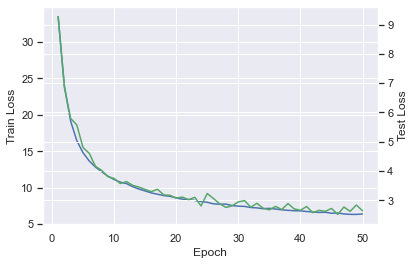

In [4]:
loss_df = pd.DataFrame({"Epoch":[i+1 for i in range(0,len(losses[0]))],"Train Loss":losses[0],"Test Loss":losses[1]})
loss_df["delta"] = loss_df["Train Loss"] - loss_df["Test Loss"]
sns.lineplot(data=loss_df[:],x="Epoch",y="Train Loss")
ax2 = plt.twinx()
sns.lineplot(data=loss_df[:],x="Epoch",y="Test Loss", color="g", ax=ax2)

In [5]:
model.predict(dataset[4999:5005]["context"]), dataset[4999:5005]["target"]

(tensor([18, 10,  7,  6,  5,  3]), tensor([18, 24,  7,  6,  4,  3]))

In [7]:
import folium

In [15]:
locations = pd.read_csv("data/points.csv")
locations.shape

(82, 3)

In [36]:
location_index = {}

for i, location in locations.iterrows():
    location_index[int(location[0])] = [location[1],location[2]]

    

# Look at 5000

In [71]:
target_pred = int(model.predict(dataset[5000]["context"]))
context = [int(i) for i in dataset[5000]["context"]]
target_actual = int(dataset[5000]["target"])

context_ll = []
for c in context:
    context_ll.append(location_index[c])

actual_ll = location_index[target_actual]
pred_ll = location_index[target_pred]
m = folium.Map(location=pred_ll,zoom_start=15)

for i,ll in enumerate(context_ll):
    # folium.CircleMarker((ll[0],ll[1]),radius=3,tooltip=i).add_to(m)
    folium.Circle((ll[0],ll[1]), radius=30, color="forestgreen",tooltip=i).add_to(m)

folium.Circle(actual_ll, radius=30, color="red",tooltip="actual").add_to(m)
folium.Circle(pred_ll, radius=15, color="blue",tooltip="predicted").add_to(m)


m